In [2]:
import sys
import os
sys.path.insert(0, '/Users/lerinalaluf/Desktop/SIP_2021/kaepora/src')
os.chdir('/Users/lerinalaluf/Desktop/SIP_2021/kaepora/src')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import kaepora as kpora
import numpy as np
import matplotlib.pyplot as plt

In [5]:
spectra_query = ["SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where (phase <= 3 and phase >= -3) and ((dm15_source < 1.2 and dm15_source > 1) or (dm15_from_fits < 1.2 and dm15_from_fits > 1)) and (v_at_max < -8.5)"]

In [6]:
spec_array = kpora.grab(spectra_query[0], db_file = '../data/kaepora_v1_DEV.db', make_corr = True)

182 Total Spectra found
8 flagged spectra removed 174 spectra left
0 spectra of peculiar Ias removed 174 spectra left
147 spectra of SNe that have host reddening corrections
Arrays cleaned


In [7]:
def fluxGrid(spec_array):
    
    MINSTART = spec_array[0].x1
    MINEND = spec_array[0].x2

    for spec in spec_array:
        if spec.x1 < MINSTART:
            MINSTART = spec.x1
        if spec.x2 > MINEND:
            MINEND = spec.x2
    
    all_data = 0.0

    for spec in spec_array:
        all_data += len(spec.flux[~np.isnan(spec.flux)])
    
    length = len(spec_array[0].flux[~np.isnan(spec_array[0].flux)])

    for spec in spec_array:
        if length > len(spec.flux[~np.isnan(spec.flux)]):
            length = len(spec.flux[~np.isnan(spec.flux)])
    
    total_data = all_data
    data_percent = 0.0

    start = MINSTART

    bestStart = None
    bestLength = None

    while (start + length - 1 <= MINEND):
        total_data = all_data

        while (start + length - 1 <= MINEND):
            num_cols = len(spec_array)
            
            for spec in spec_array:
                array_start = spec.flux[:start]
                array_end = spec.flux[(start + length - 1):]
                new_array = spec.flux[start:(start + length)]

                total_data -= len(array_start[~np.isnan(array_start)])
                total_data -= len(array_end[~np.isnan(array_end)])

                if any(np.isnan(new_array)):
                    total_data -= len(new_array[~np.isnan(new_array)])
                    num_cols -= 1

            new_data = total_data/all_data

            if new_data > data_percent:
                data_percent = new_data
                bestStart = start
                bestLength = length
                best_num_cols = num_cols

            total_data = all_data
            start += 100

        start = MINSTART 
        length += 100
    
    MIN = bestStart
    MAX = bestStart + bestLength - 1

    num_rows = bestLength
    num_cols = best_num_cols
    
    grid = []
    k = 0
    
    while len(grid) < num_cols:
        if any(np.isnan(spec_array[k].flux)[MIN:(MAX + 1)]):
            spec_array.pop(k)
        if all(~np.isnan(spec_array[k].flux)[MIN:(MAX + 1)]):
            grid.append(spec_array[k].flux[MIN:(MAX + 1)])
            k += 1
    
    print num_cols
    np.savetxt('../../Filtered_Flux_Grid_Velocity', grid)
    
    print (MIN, MAX)
    
    print (spec_array[0].wavelength[MIN], spec_array[0].wavelength[MAX])
    return (MIN, MAX, grid)

In [8]:
MIN, MAX, grid = fluxGrid(spec_array)
spec_array = spec_array[:len(grid)]

126
(1361, 2956)
(3722.0, 6912.0)


After Sequencer:

In [9]:
data = np.loadtxt("../../Velocity_Sequence")
data = data.astype(int)
print data

[116  77  78  14  39  38  37 107 108   3 100  47  25  48 106  26  46  18
  24  17  62  40  97  23  61  45   0  27  22  60  59  21  87  88  34  86
   6  85  16  43  64  44   2  42  84  15  98  79   1   5  35  82 121 120
 113  83  81 119  80  33 118  32 125  58  36 117  57  52  73  50  74 124
 112  51  54  31 104 111  30  72  94 105  49  29 110  56   9  92 101  75
 109  28  66  67  90  91  11  63 103  95  19  68   8 122  71  12  53   7
  96  41  13  69  65  55  89  93  70 123  99 114 115 102  20   4  76  10]


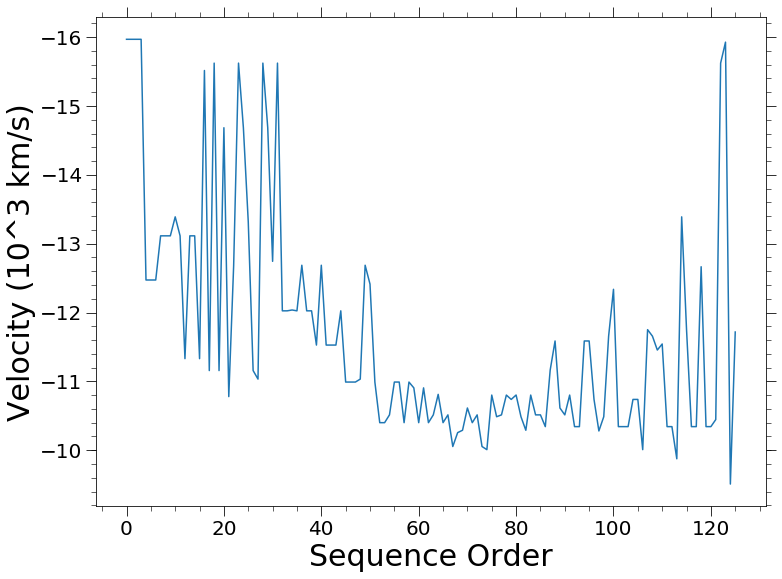

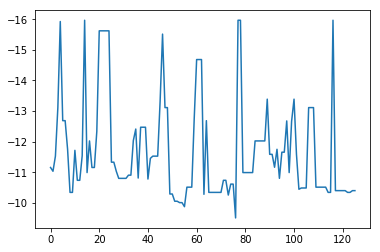

In [10]:
ordered_array = []

for i in data:
    ordered_array.append(spec_array[i].event_data['V_at_max'])

plt.figure(figsize=(12,9))
plt.xlabel("Sequence Order", fontsize = 30)
plt.ylabel("Velocity (10^3 km/s)", fontsize = 30)

plt.gca().invert_yaxis()

plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.plot(ordered_array)
plt.savefig('../../Velocity_Plot.png', dpi = 300, bbox_inches = 'tight')
plt.show()

unordered_array = []

for spec in spec_array:
    unordered_array.append(spec.event_data['V_at_max'])

plt.gca().invert_yaxis()
plt.plot(unordered_array)
plt.show()

Outlier Diagnostic Tools:

122 -15.6234
123 -15.9279


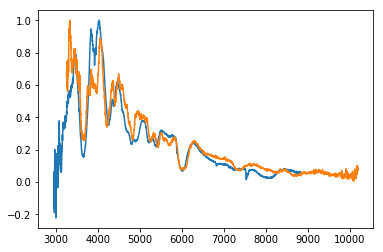

In [11]:
outlier_estimate = 123
y = -15

i = outlier_estimate - 5
k = outlier_estimate + 5

if k >= len(spec_array):
    k = len(spec_array) - 1

if i < 0:
    i = 0

while i <= k:
    if spec_array[data[i]].event_data['V_at_max'] < y:
        wavelength = spec_array[data[i]].wavelength
        flux = spec_array[data[i]].flux
        plt.plot(wavelength, flux)
        print i, spec_array[data[i]].event_data['V_at_max']
    i += 1

125 -11.717
124 -9.50819
123 -15.9279
122 -15.6234
121 -10.445
120 -10.3425
119 -10.3425


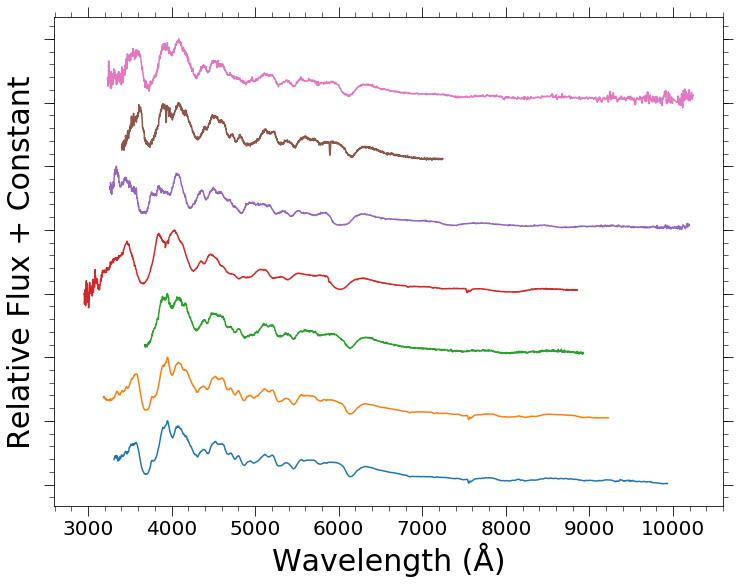

In [12]:
outlier = 122

i = outlier - 3
k = outlier + 3
j = 0

if k >= len(spec_array):
    k = len(spec_array) - 1

if i < 0:
    i = 0

plt.figure(figsize=(12,9))
plt.xlabel(u"Wavelength (Å)", fontsize = 30)
plt.ylabel("Relative Flux + Constant", fontsize = 30)

plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.gca().axes.yaxis.set_ticklabels([])

while i <= k:
    wavelength = spec_array[data[i]].wavelength
    flux = spec_array[data[i]].flux
    plt.plot(wavelength, flux + j)
    print k - j, spec_array[data[k - j]].event_data['V_at_max']
    i += 1
    j += 1

plt.show()

Composites:

In [13]:
num_comp = 10

file_name_array = []
k = 0

while k < len(data):
    farray = []
    for i in data[k:k+len(data)/num_comp]:
        farray.append(spec_array[i].filename)
    file_name_array.append(farray)
    k += len(data)/num_comp

query_strings = []

for files in file_name_array:
    i = 1
    string = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where "
    for file in files:
        string += "filename = '%s'"% (file)
        if i < len(files):
            string += ' or '
        i += 1
    query_strings.append(string)

composites, sn_arrays, boot_sn_arrays = kpora.make_composite(query_strings, boot=False, medmean=1, gini_balance=True, verbose=False, shape_param='dm15', av_corr = False)

SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where filename = '2006X_20060219_3731_8515_00.dat' or filename = 'sn2006X-20060221.40-fast.flm' or filename = 'sn2006X-20060222.41-fast.flm' or filename = 'sn2006x-20060222.413-ui.flm' or filename = 'sn1999cl-19990614.18-fast.flm' or filename = 'sn1999cl-19990612.17-fast.flm' or filename = 'sn1999cl-19990611.18-fast.flm' or filename = '2002bo_20020322_3200_8974_00.dat' or filename = '2002bo_20020323_3356_10385_00.dat' or filename = 'sn2002bo-20020322-ui-corrected.flm' or filename = 'SN07jg_070922_b01_CLA_LD.dat' or filename = 'sn2002bo-20020321.24-fast.flm'
12 Total Spectra found
0 flagged spectra removed 12 spectra left
0 spectra of peculiar Ias removed 12 spectra left
12 spectra of SNe that have host reddening corrections
Arrays cleaned
12 spectra may have telluric contamination
4 total SNe
removed spectra of SNe with A_V > 2.0
Using 12 spectra of 4 SNe
Gini balancing...
Balanced after 5 iterations
SQL Query

12 Total Spectra found
0 flagged spectra removed 12 spectra left
0 spectra of peculiar Ias removed 12 spectra left
12 spectra of SNe that have host reddening corrections
Arrays cleaned
0 spectra may have telluric contamination
8 total SNe
removed spectra of SNe with A_V > 2.0
Using 12 spectra of 8 SNe
Gini balancing...
Balanced after 3 iterations
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where filename = 'SN05hc_051024_b01_MGH_BC.dat' or filename = 'sn2001az-20010430.40-fast.flm' or filename = 'sn2006cz-20060626.304-ui.flm' or filename = 'sn2005cf-20050614.31-fast.flm' or filename = 'sn2005cf-20050610.34-fast.flm' or filename = 'sn2002hu-20021113.25-fast.flm' or filename = 'sn2007jg-20070920.46-fast.flm' or filename = 'SN05ag_050212_b01_DUP_WF.dat' or filename = 'sn2005cf-20050615.24-fast.flm' or filename = 'sn2005cf-20050611.6-uvot.flm' or filename = 'SN07as_070319_b01_DUP_BC.dat' or filename = '2005cf_20050611_3331_9999_00.dat'
12 Total Spectra foun

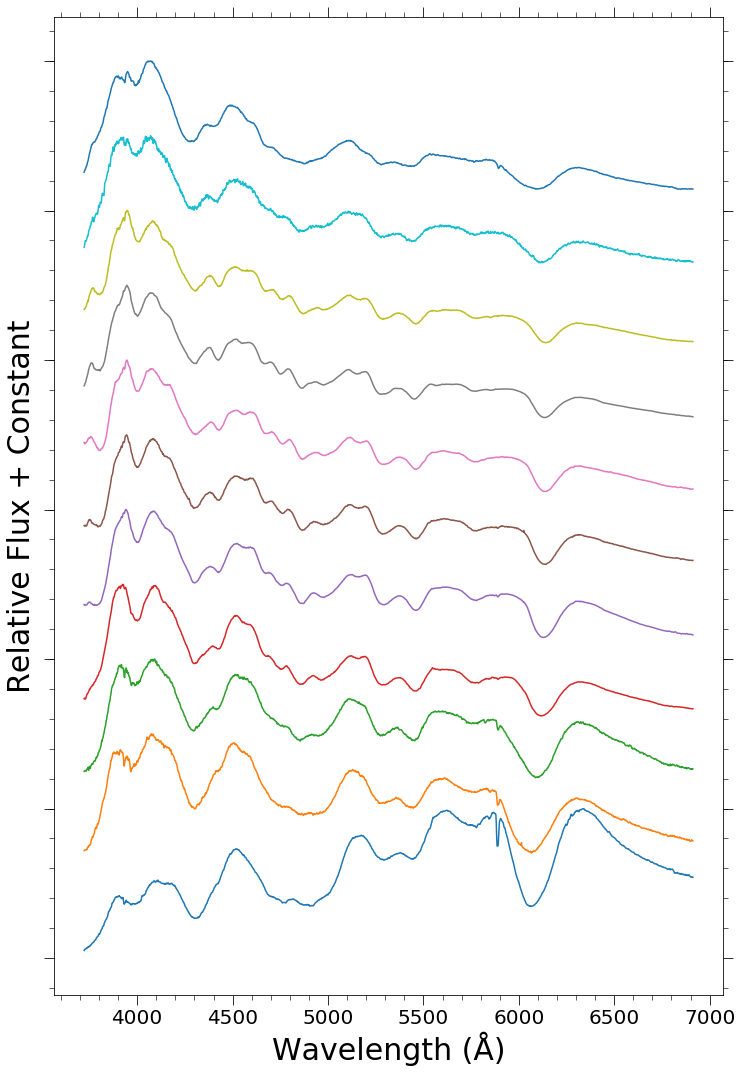

In [14]:
plt.figure(figsize=(12,18))
plt.xlabel(u"Wavelength (Å)", fontsize = 30)
plt.ylabel("Relative Flux + Constant", fontsize = 30)

plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.gca().axes.yaxis.set_ticklabels([])

k = 0

for composite in composites:
    wavelength = composite.wavelength[MIN:(MAX + 1)]
    flux = composite.flux[MIN:(MAX + 1)]
    plt.plot(wavelength, flux + k)
    k += 0.5

plt.savefig('../../Velocity_Composites.png', dpi = 300, bbox_inches = 'tight')
plt.show()

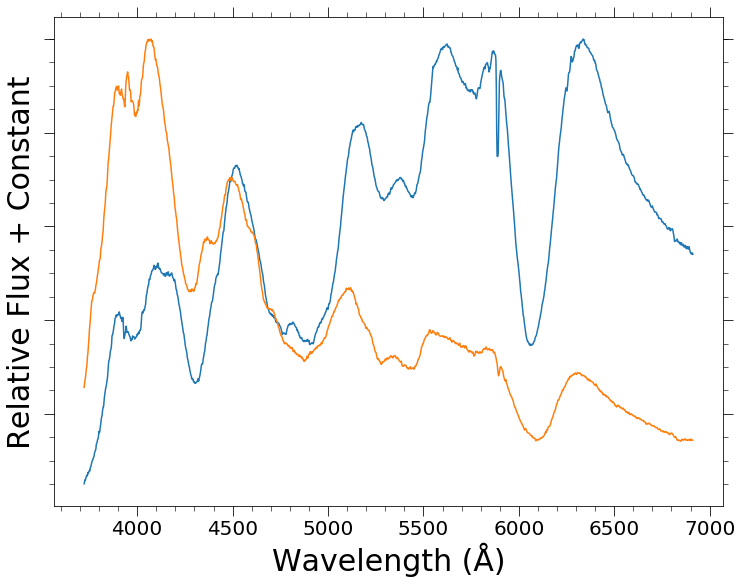

In [15]:
plt.figure(figsize=(12,9))
plt.xlabel(u"Wavelength (Å)", fontsize = 30)
plt.ylabel("Relative Flux + Constant", fontsize = 30)

plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.gca().axes.yaxis.set_ticklabels([])

k = 0

# for composite in composites:
#     wavelength = composite.wavelength[MIN:(MAX + 1)]
#     flux = composite.flux[MIN:(MAX + 1)]
#     plt.plot(wavelength, flux + k)
#     k += 0.4

wavelength = composites[0].wavelength[MIN:(MAX + 1)]
flux = composites[0].flux[MIN:(MAX + 1)]
plt.plot(wavelength, flux + k)

wavelength = composites[-1].wavelength[MIN:(MAX + 1)]
flux = composites[-1].flux[MIN:(MAX + 1)]
plt.plot(wavelength, flux + k)

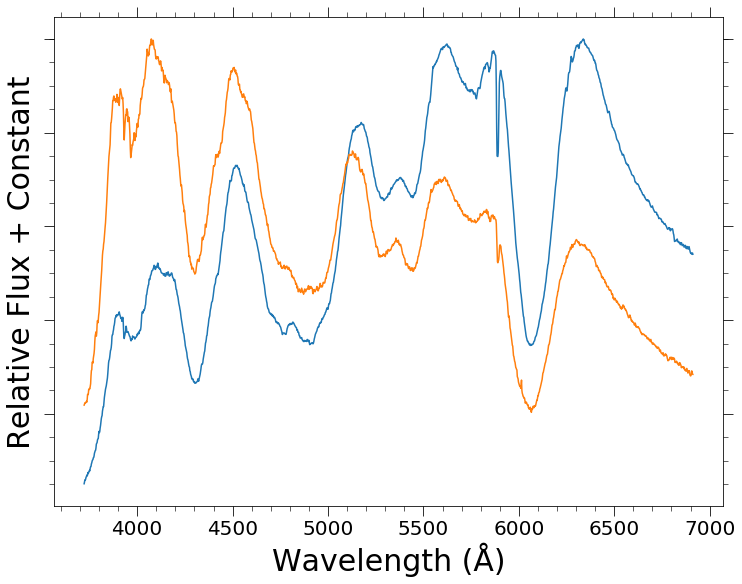

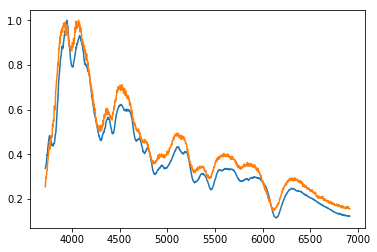

In [19]:
plt.figure(figsize=(12,9))
plt.xlabel(u"Wavelength (Å)", fontsize = 30)
plt.ylabel("Relative Flux + Constant", fontsize = 30)

plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.gca().axes.yaxis.set_ticklabels([])

k = 0

# for composite in composites:
#     wavelength = composite.wavelength[MIN:(MAX + 1)]
#     flux = composite.flux[MIN:(MAX + 1)]
#     plt.plot(wavelength, flux + k)
#     k += 0.4

wavelength = composites[0].wavelength[MIN:(MAX + 1)]
flux = composites[0].flux[MIN:(MAX + 1)]
plt.plot(wavelength, flux + k)

wavelength = composites[1].wavelength[MIN:(MAX + 1)]
flux = composites[1].flux[MIN:(MAX + 1)]
plt.plot(wavelength, flux + k)

plt.show()

wavelength = composites[-3].wavelength[MIN:(MAX + 1)]
flux = composites[-3].flux[MIN:(MAX + 1)]
plt.plot(wavelength, flux + k)

wavelength = composites[-2].wavelength[MIN:(MAX + 1)]
flux = composites[-2].flux[MIN:(MAX + 1)]
plt.plot(wavelength, flux + k)

plt.show()